In [1]:
import numpy as np
from math import*
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats

plt.rcParams["figure.figsize"] = (8,8)

In [2]:
class CauchyBandit :
    def __init__(self, loc, scale, seed = None):
        ''' Entrées:
                - loc: un array décrivant les paramètres de localisations des lois de Cauchy décrivant les actions
                - scale: un array décrivant les paramètres d'échelle des lois de Cauchy décrivant les actions
                - seed (optionnel): un seed. 
        '''

        np.random.seed(seed=seed)
        
        self.loc = loc
        
        self.scale= scale
        
        self.ps_regrets = []

        self.locstar = max(self.loc)
        
        self.kstar = np.argmax(loc)
        
        self.gaps = self.locstar - loc

        
    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.loc)
        
        return K
        
    def play(self,action):
        ''' Accept a parameter 0 <= k < K, logs the instant pseudo - regret ,
        and return the realization of a Bernoulli random variable with P(X =1)
        being the mean of the given action . '''

        #méthode de conténation append
        self.ps_regrets.append(self.gaps[action])
        
        reward = scipy.stats.cauchy.rvs(self.loc[action], self.scale[action],size=1)
        
        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

Definition des algorithme que nous allons tester

In [3]:
def etc(bandit , T, estimator, m, discret=False):
    '''T: L'horizon
       m: Le nombre de tirage de chacune des actions dans le tour exploratoire
       discret: Pour faire un bris d'égalité ou non (nécessaire dans le cas de distributions discrètes)
       estimator: une lambda calculant l'estimation empirique '''
     
    K = bandit.get_K() #Obtention du nombre d'actions possibles.
        
    # Phase d'exploration (m tours sur chaque action)
    estimateurs = []
    for k in range(bandit.get_K()):
        m_estimateurs = []
        for i in range(m):
            m_estimateurs.append(bandit.play(k))
        estimateurs.append(estimator(m_estimateurs))

    # Calcul de l'action optimale

    ##Si la loi des bras est discrète, on doit gérer le cas où il peut y avoir bris d'égalité. 
    if(discret):
        kstar_est = np.where(estimateurs == max(estimateurs))[0]

        if (len(kstar_est) > 1):
            kstar_est = np.random.choice(kstar_est,1)[0]
    else:
        kstar_est = np.argmax(estimateurs)
            
    # Phase d'exploitation

    for t in range(m*K,T):
        r_t=bandit.play(kstar_est)

    return kstar_est

In [4]:
def epsilon_greedy(bandit, T, estimator, epsilon, seed=None):
    random = np.random.RandomState(seed)
    K = bandit.get_K()
    r = np.zeros(T)

    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K) 
                                        
    #Le jeu commence
    for t in range(T):
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
        estimateur[action_played]=estimator(R[action_played])

Definition des différentes fonctions d'estimations que nous allons tester

In [5]:
def mean_estimator(X):
    return np.mean(X)

In [6]:
def median_estimator(X):
    return np.median(X)

In [7]:
def truncated_mean_estimator(X, tmean):
    return scipy.stats.trim_mean(X, tmean)

In [8]:
def l_estimator(X):
    N = len(X)
    estimation = 0
    x_sorted = np.sort(X)

    for i in range(N):
        u = (i+1) / (N+1)
        tan_value=tan(np.pi * (u - 0.5))
        sin_value=sin(4* np.pi * (u - 0.5))
        if tan_value==0:
            coefficient=4
        else:
            coefficient=sin_value/tan_value
        
        estimation += coefficient*x_sorted[i]
    
    return estimation / N

In [9]:
def maximum_likelihood_estimator(X, tolerance=0.001, max_steps=500):
    LOG_LIKELIHOOD_DERIVATIVE = lambda x, theta: 2 * sum((x - theta) / (1 + (x - theta)**2))
    theta_estimation = np.median(X)

    first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)
    for step in range(max_steps):
        if abs(first_deriv) < tolerance:
            break
        second_deriv = 2 * sum(((X - theta_estimation)**2 - 1) / (1 + (X - theta_estimation)**2)**2)
        theta_estimation = theta_estimation - first_deriv / second_deriv
        first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)

    return theta_estimation

In [10]:
def chauchy_expertiment(algorithm, estimator, scale, get_location, episodes=100, steps=5000, get_seed=lambda i: None, plot_fct=None):
    cumulative_regret = []
    
    for i in range(episodes):
        bandit = CauchyBandit(loc=get_location(i), scale=scale, seed=get_seed(i))
        algorithm(bandit, T=steps, estimator=estimator, episode=i)
        cumulative_regret.append(bandit.get_cumulative_regret())
        
    mean_cumulative_regret = np.apply_along_axis(np.mean, 0, cumulative_regret)
    std_cumulative_regret = np.apply_along_axis(np.std, 0, cumulative_regret)
    
    if plot_fct is not None:
        plot_fct(mean_cumulative_regret, std_cumulative_regret)

    return mean_cumulative_regret, std_cumulative_regret

In [11]:
def plot_experiment(mean, std, label='', color=None, fill_between=False):
    plt.plot(range(len(mean)), mean, color=color, label=label)
    if fill_between:
        plt.fill_between(range(len(mean)), mean, mean + std, color=color, alpha=0.3)
    else:
        plt.plot(range(len(mean)), mean + std,color=color, linestyle='dashed')

Text(0.5, 1.0, 'Estimators experiments on ETC algorithme with m = 20')

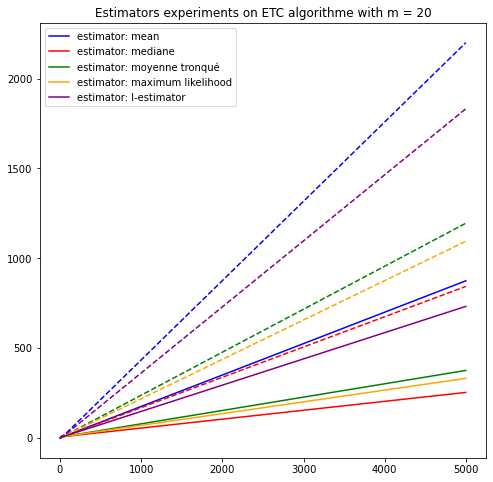

In [20]:
N = 50
T = 5000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

m = 20

etc_wrapper = lambda *args, episode, **kargs: etc(*args, **kargs, m=m, discret=False)

loc=loc=np.random.rand(N, 2)
scale=np.array([1,1])

chauchy_expertiment(
    etc_wrapper,
    mean_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
)

chauchy_expertiment(
    etc_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    etc_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    etc_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    etc_wrapper,
    l_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on ETC algorithme with m = {m}")

Text(0.5, 1.0, 'Estimators experiments on Ɛ-greedy algorithme with Ɛ = 0.1')

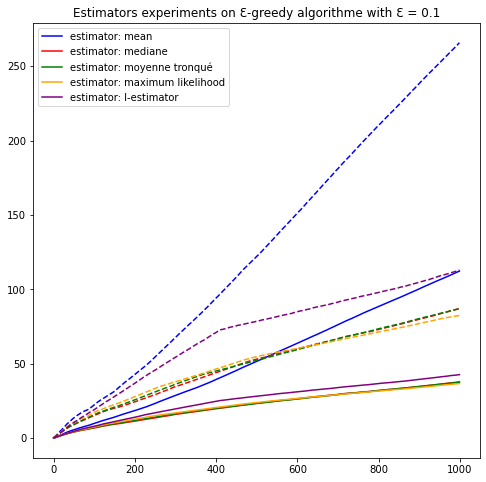

In [18]:
N = 50
T = 1000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_wrapper = lambda *args, episode, **kargs: epsilon_greedy(*args, **kargs, epsilon=EPSILON, seed=SEEDS[episode])

loc=loc=np.random.rand(N, 2)
scale=np.array([1,1])

chauchy_expertiment(
    epsilon_greedy_wrapper,
    mean_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    l_estimator,
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on Ɛ-greedy algorithme with Ɛ = {EPSILON}")